In [ ]:
# Install required libraries
!pip install pycryptodome phe psutil

# Imports
import pandas as pd
import random
import time
from phe import paillier

# for key managment
import os
import psutil
import struct

In [ ]:
# DNA Mapping
DNA_MAPPING = {
    '00': 'A',
    '01': 'C',
    '10': 'G',
    '11': 'T'
}
DNA_REVERSE_MAPPING = {v: k for k, v in DNA_MAPPING.items()}

# XOR Encryption
def xor_encrypt(data: bytes, key: bytes) -> bytes:
    key = key * (len(data) // len(key)) + key[:len(data) % len(key)]
    return bytes([d ^ k for d, k in zip(data, key)])

# XNOR Encryption (not used in main pipeline but available)
def xnor_encrypt(data: bytes, key: bytes) -> bytes:
    key = key * (len(data) // len(key)) + key[:len(data) % len(key)]
    return bytes([~(d ^ k) & 0xFF for d, k in zip(data, key)])

# Bit shift
def bit_shift(data: bytes, shift_by: int = 1, direction: str = 'left') -> bytes:
    if direction == 'left':
        return bytes([(b << shift_by | b >> (8 - shift_by)) & 0xFF for b in data])
    else:
        return bytes([(b >> shift_by | b << (8 - shift_by)) & 0xFF for b in data])

# Binary ↔ DNA
def binary_to_dna(data: bytes) -> str:
    binary_string = ''.join(f'{byte:08b}' for byte in data)
    return ''.join(DNA_MAPPING[binary_string[i:i+2]] for i in range(0, len(binary_string), 2))

def dna_to_binary(dna_sequence: str) -> bytes:
    binary_string = ''.join(DNA_REVERSE_MAPPING[base] for base in dna_sequence)
    # Pad if needed to make multiple of 8
    if len(binary_string) % 8 != 0:
        binary_string = binary_string.ljust((len(binary_string) // 8 + 1) * 8, '0')
    byte_list = [int(binary_string[i:i+8], 2) for i in range(0, len(binary_string), 8)]
    return bytes(byte_list)

# Full Genetic Encrypt/Decrypt (Layer 1)
def genetic_encrypt(data: bytes, key: bytes) -> str:
    xor_encrypted = xor_encrypt(data, key)
    shifted = bit_shift(xor_encrypted, shift_by=2, direction='left')
    return binary_to_dna(shifted)

def genetic_decrypt(dna_sequence: str, key: bytes) -> bytes:
    binary_data = dna_to_binary(dna_sequence)
    unshifted = bit_shift(binary_data, shift_by=2, direction='right')
    return xor_encrypt(unshifted, key)

# Helper functions for converting between different representations
def float_to_bytes(value):
    """Convert float to bytes"""
    return struct.pack('!f', value)

def bytes_to_float(bytes_val):
    """Convert bytes to float"""
    return struct.unpack('!f', bytes_val)[0]

def dna_to_int(dna_seq):
    """Convert DNA sequence to integer suitable for homomorphic encryption"""
    binary = dna_to_binary(dna_seq)
    truncated = binary[:min(8, len(binary))]
    return int.from_bytes(truncated, byteorder='big')

def int_to_dna(integer, original_dna_length):
    """Convert integer back to DNA sequence"""
    # Convert integer to bytes
    byte_val = integer.to_bytes((integer.bit_length() + 7) // 8, byteorder='big')
    dna = binary_to_dna(byte_val)
    return dna.ljust(original_dna_length, 'A')

In [ ]:
# Enhanced Key Manager with Envelope Encryption (DEK/KEK model)
class EnvelopeKeyManager:
    def __init__(self, rotation_interval=3600, key_ttl=7200):
        """Initialize key manager with rotation interval and time-to-live values in seconds

        Args:
            rotation_interval: How often KEKs should be rotated in seconds
            key_ttl: How long KEKs remain valid after creation in seconds
        """
        self.rotation_interval = rotation_interval
        self.key_ttl = key_ttl

        # Storage for Key Encryption Keys (KEKs)
        self.key_encryption_keys = {}  # version -> KEK
        self.archived_keks = {}        # version -> KEK (expired but still needed)

        self.current_kek_version = 0
        self.last_rotation = 0

        # For homomorphic encryption
        self.he_instances = {}

        # Create initial KEK
        self.rotate_keys()

    def rotate_keys(self):
        """Generate new Key Encryption Key (KEK)"""
        self.current_kek_version += 1
        self.last_rotation = time.time()

        # Generate a random 16-byte key for genetic encryption (KEK)
        kek = bytes([random.randint(0, 255) for _ in range(16)])

        # Create new homomorphic encryption instance
        he_instance = PaillierHE()

        self.key_encryption_keys[self.current_kek_version] = {
            'kek': kek,
            'he_instance': he_instance,
            'created_at': self.last_rotation
        }

        self.he_instances[self.current_kek_version] = he_instance

        print(f"KEK rotated: New version {self.current_kek_version} created")
        return self.current_kek_version

    def get_current_kek(self, force_rotation=False):
        """Get the current KEK and version"""
        now = time.time()

        # Check if we need to rotate keys
        if force_rotation or (now - self.last_rotation > self.rotation_interval):
            self.rotate_keys()

        # Clean expired KEKs
        self._archive_expired_keks()

        return (self.current_kek_version,
                self.key_encryption_keys[self.current_kek_version]['kek'],
                self.key_encryption_keys[self.current_kek_version]['he_instance'])

    def is_kek_valid(self, version):
        """Check if a specific KEK version is still valid"""
        if version not in self.key_encryption_keys:
            return False
        return (time.time() - self.key_encryption_keys[version]['created_at']) < self.key_ttl

    def _archive_expired_keks(self):
        """Move expired KEKs to archive instead of deleting"""
        now = time.time()
        expired = [v for v in self.key_encryption_keys.keys()
                  if now - self.key_encryption_keys[v]['created_at'] > self.key_ttl]

        for v in expired:
            if v != self.current_kek_version:  # Don't remove current KEK
                print(f"KEK version {v} expired and archived")
                self.archived_keks[v] = self.key_encryption_keys[v]
                del self.key_encryption_keys[v]

    def generate_dek(self):
        """Generate a new Data Encryption Key (DEK)"""
        # Generate a random 16-byte DEK
        return bytes([random.randint(0, 255) for _ in range(16)])

    def encrypt_dek(self, dek, kek_version=None):
        """Encrypt a DEK using the specified KEK"""
        if kek_version is None:
            kek_version, kek, _ = self.get_current_kek()
        else:
            kek = self._get_kek_by_version(kek_version)['kek']

        # Encrypt DEK using the KEK with XOR (for simplicity)
        # In a real system, you would use a proper encryption algorithm
        encrypted_dek = xor_encrypt(dek, kek)

        return {
            'encrypted_dek': encrypted_dek,
            'kek_version': kek_version
        }

    def decrypt_dek(self, encrypted_dek_package):
        """Decrypt a DEK using the appropriate KEK"""
        kek_version = encrypted_dek_package['kek_version']
        encrypted_dek = encrypted_dek_package['encrypted_dek']

        # Get the KEK (from active or archived keys)
        kek_info = self._get_kek_by_version(kek_version)
        kek = kek_info['kek']

        # Decrypt the DEK
        return xor_encrypt(encrypted_dek, kek)  # XOR decrypts the same way

    def _get_kek_by_version(self, version):
        """Get a KEK by version from either active or archived keys"""
        if version in self.key_encryption_keys:
            return self.key_encryption_keys[version]
        elif version in self.archived_keks:
            return self.archived_keks[version]
        else:
            raise KeyError(f"KEK version {version} not found in active or archived keys")

    def get_he_instance(self, version):
        """Get the homomorphic encryption instance for a specific version"""
        kek_info = self._get_kek_by_version(version)
        return kek_info['he_instance']

    def update_encrypted_dek(self, encrypted_dek_package):
        """Re-encrypt a DEK with the current KEK if the original KEK is expiring"""
        old_version = encrypted_dek_package['kek_version']

        # If the old KEK is still valid and not close to expiring, no need to update
        if self.is_kek_valid(old_version):
            time_remaining = (self.key_encryption_keys[old_version]['created_at'] +
                             self.key_ttl - time.time())

            # Only update if less than 20% of TTL remains
            if time_remaining > 0.2 * self.key_ttl:
                return encrypted_dek_package

        # Decrypt the DEK using the old KEK
        dek = self.decrypt_dek(encrypted_dek_package)

        # Re-encrypt with current KEK
        return self.encrypt_dek(dek)

    def simulate_attack_rate(self, attempts_per_second=1000):
        """Simulate brute force attack success probability"""
        key_space = 2**(8*16)  # 16 byte key = 2^128 possibilities
        time_to_crack = key_space / attempts_per_second / 2  # Average case

        print(f"Simulated brute force attack:")
        print(f"- Key space: 2^128 (16-byte key)")
        print(f"- At {attempts_per_second} attempts/second")
        print(f"- Average time to crack: {time_to_crack/(60*60*24*365):e} years")
        print(f"- Key valid for: {self.key_ttl/3600:.1f} hours")

        # Probability of successful crack within TTL
        p_success = (attempts_per_second * self.key_ttl) / key_space
        print(f"- Probability of successful crack within key TTL: {p_success:e}")

In [ ]:

# Load dataset
def load_wine_dataset(filepath,name):
    return pd.read_csv(name, sep=';')

# Load dataset
def load_healthcare_dataset(filepath,name):
    return pd.read_csv(name, sep=',')


In [ ]:
# Paillier Homomorphic Encryption Class
class PaillierHE:
    def __init__(self):
        self.pub_key, self.priv_key = paillier.generate_paillier_keypair()

    def encrypt(self, value: int):
        return self.pub_key.encrypt(value)

    def decrypt(self, ctxt):
        return self.priv_key.decrypt(ctxt)

    def add(self, ctxt1, ctxt2):
        return ctxt1 + ctxt2

    def mul_scalar(self, ctxt, scalar: int):
        return ctxt * scalar

In [ ]:
# Envelope Encryption combining all three layers
def envelope_encrypt(value, key_manager):
    """Envelope encryption (DEK/KEK model) with genetic and homomorphic layers"""
    start = time.time()

    # Step 1: Generate a new DEK for this data
    dek = key_manager.generate_dek()

    # Step 2: Get current KEK for encrypting the DEK
    kek_version, _, he_instance = key_manager.get_current_kek()

    # Step 3: Encrypt the DEK with the KEK
    encrypted_dek_package = key_manager.encrypt_dek(dek)

    # Step 4: Convert value to bytes
    if isinstance(value, float):
        byte_val = float_to_bytes(value)
    else:
        byte_val = str(value).encode()

    # Step 5: Layer 1 - Encrypt data with DEK using genetic encryption
    dna_seq = genetic_encrypt(byte_val, dek)

    # Step 6: Convert DNA to integer for homomorphic encryption
    int_val = dna_to_int(dna_seq)

    # Step 7: Layer 2 - Homomorphic Encryption
    encrypted = he_instance.encrypt(int_val)

    # Store metadata needed for decryption
    encrypted_package = {
        'encrypted_data': encrypted,
        'encrypted_dek': encrypted_dek_package,
        'dna_length': len(dna_seq),
        'he_version': kek_version
    }

    duration = time.time() - start
    return encrypted_package, duration

def envelope_decrypt(encrypted_package, key_manager):
    """Decrypt data that was encrypted with envelope_encrypt"""
    start = time.time()

    # Step 1: Extract components from the package
    encrypted_dek_package = encrypted_package['encrypted_dek']

    # Step 2: Decrypt the DEK using the appropriate KEK
    dek = key_manager.decrypt_dek(encrypted_dek_package)

    # Step 3: Use the stored genetic data directly instead of trying to derive it
    if 'genetic_data' in encrypted_package:
        # Use the stored DNA sequence directly
        dna_seq = encrypted_package['genetic_data']
    else:
        # Fallback to old method if genetic_data isn't available
        encrypted_data = encrypted_package['encrypted_data']
        dna_length = encrypted_package['dna_length']
        he_version = encrypted_package['he_version']
        he_instance = key_manager.get_he_instance(he_version)
        decrypted_int = he_instance.decrypt(encrypted_data)
        dna_seq = int_to_dna(decrypted_int, dna_length)

    # Step 4: Perform genetic decryption
    decrypted_bytes = genetic_decrypt(dna_seq, dek)

    # Step 5: Convert bytes back to original format
    if encrypted_package.get('is_float', False):
        # For floating point values
        decrypted_value = bytes_to_float(decrypted_bytes[:4])
    else:
        try:
            # Try string conversion
            decrypted_value = decrypted_bytes.decode()
        except:
            # Last resort, return as bytes
            decrypted_value = decrypted_bytes

    duration = time.time() - start
    return decrypted_value, duration

# Add this to implement proper numeric scaling for homomorphic operations
def envelope_encrypt_with_kek(value, kek_version, kek, he_instance, key_manager):
    """Envelope encryption with proper numerical handling"""
    start = time.time()

    # Generate a DEK for this data
    dek = key_manager.generate_dek()

    # Encrypt the DEK with the KEK
    encrypted_dek = xor_encrypt(dek, kek)
    encrypted_dek_package = {
        'encrypted_dek': encrypted_dek,
        'kek_version': kek_version
    }

    # Special handling for numeric values
    scale_factor = 1000  # For 3 decimal places of precision

    if isinstance(value, float):
        # For homomorphic operations, directly encrypt scaled integer
        scaled_int_val = int(value * scale_factor)
        homomorphic_encrypted = he_instance.encrypt(scaled_int_val)

        # For normal encryption, proceed with genetic layer
        byte_val = float_to_bytes(value)
        dna_seq = genetic_encrypt(byte_val, dek)
    else:
        byte_val = str(value).encode()
        dna_seq = genetic_encrypt(byte_val, dek)
        homomorphic_encrypted = he_instance.encrypt(0)  # Default value

    encrypted_package = {
        'encrypted_data': homomorphic_encrypted,
        'encrypted_dek': encrypted_dek_package,
        'dna_length': len(dna_seq),
        'genetic_data': dna_seq,  # Store DNA sequence directly
        'he_version': kek_version,
        'is_float': isinstance(value, float),
        'scale_factor': scale_factor
    }
    print(f"Encrypted value: {value} -> {encrypted_package}")

    duration = time.time() - start
    return encrypted_package, duration

# Process dataset using envelope encryption
def process_wine_data_envelope(df, columns, key_manager):
    """Process wine dataset through envelope encryption"""
    results = {
        'encrypt_times': [],
        'encrypted_data': {},
        'original_data': {},
        'encrypted_packages': {}
    }

    # Get KEK once before processing all values
    kek_version, kek, he_instance = key_manager.get_current_kek()

    total_values = len(df) * len(columns)
    processed = 0

    for col in columns:
        encrypted_packages = []
        encrypt_times = []

        # Store original data for validation
        results['original_data'][col] = df[col].copy()

        for idx, val in enumerate(df[col]):
            if idx % 5 == 0:  # Report every 5 items
                print(f"Processing {processed}/{total_values} values ({processed/total_values*100:.1f}%)")

            # Use the pre-fetched KEK info
            encrypted_package, duration = envelope_encrypt_with_kek(val, kek_version, kek, he_instance, key_manager)
            encrypted_packages.append(encrypted_package)
            encrypt_times.append(duration)
            processed += 1

        results['encrypted_packages'][col] = encrypted_packages
        results['encrypt_times'].extend(encrypt_times)

    return results


In [ ]:
# Testing Functions for Envelope Encryption
def test_homomorphic_with_envelope(encrypted_results, key_manager):
    """Test homomorphic operations with envelope encryption"""
    print("\n=== Testing Homomorphic Operations with Envelope Encryption ===")

    # Select a column for testing
    col = list(encrypted_results['encrypted_packages'].keys())[0]
    packages = encrypted_results['encrypted_packages'][col][:5]
    original_values = encrypted_results['original_data'][col][:5]

    print(f"Testing on column: {col}")
    print(f"Original values: {original_values.tolist()}")

    # Extract encrypted data for homomorphic operations
    encrypted_values = [pkg['encrypted_data'] for pkg in packages]

    # Get the HE instance and scale factor
    he_version = packages[0]['he_version']
    scale_factor = packages[0]['scale_factor']
    he_instance = key_manager.get_he_instance(he_version)

    # Sum the encrypted values using homomorphic addition
    encrypted_sum = encrypted_values[0]
    for value in encrypted_values[1:]:
        encrypted_sum = he_instance.add(encrypted_sum, value)

    # Decrypt the sum and descale
    raw_sum = he_instance.decrypt(encrypted_sum)
    decrypted_sum = raw_sum / scale_factor

    print(f"Homomorphic sum: {decrypted_sum}")
    print(f"Actual sum: {sum(original_values)}")
    print(f"Difference: {abs(decrypted_sum - sum(original_values))}")

    return decrypted_sum, sum(original_values)

def test_key_rotation_with_envelope(key_manager, encrypted_package):
    """Test KEK rotation without re-encrypting data"""
    print("\n=== Testing Key Rotation with Envelope Encryption ===")

    # Decrypt with current KEK
    print("Original decryption:")
    original_value, _ = envelope_decrypt(encrypted_package, key_manager)
    print(f"Decrypted value: {original_value}")

    # Force KEK rotation
    print("\nForcing KEK rotation...")
    old_kek_version = encrypted_package['encrypted_dek']['kek_version']
    key_manager.rotate_keys()

    # Decrypt with new KEK structure (should still work)
    print("\nDecrypting with new KEK structure:")
    same_value, _ = envelope_decrypt(encrypted_package, key_manager)
    print(f"Decrypted value: {same_value}")
    print(f"Value unchanged: {original_value == same_value}")

    # Update the DEK encryption to use latest KEK
    print("\nUpdating DEK encryption to use latest KEK...")
    updated_package = encrypted_package.copy()
    updated_package['encrypted_dek'] = key_manager.update_encrypted_dek(encrypted_package['encrypted_dek'])

    # Verify decryption still works with updated KEK
    updated_value, _ = envelope_decrypt(updated_package, key_manager)
    print(f"Updated package decryption: {updated_value}")
    print(f"Value unchanged: {original_value == updated_value}")

    print(f"\nOriginal KEK version: {old_kek_version}")
    print(f"Updated KEK version: {updated_package['encrypted_dek']['kek_version']}")

    return {
        'original': original_value,
        'updated': updated_value,
        'values_match': original_value == same_value
    }

def measure_envelope_performance(df, columns, key_manager):
    """Measure envelope encryption performance"""
    print("\n=== Envelope Encryption Performance ===")

    process = psutil.Process(os.getpid())

    # Measure memory before
    mem_before = process.memory_info().rss / 1024 / 1024  # MB

    # Measure CPU and time for encryption
    cpu_before = process.cpu_percent(interval=None)
    start_time = time.time()

    # Process data through encryption
    encrypted_results = process_wine_data_envelope(df, columns, key_manager)

    # Calculate metrics
    encrypt_time = time.time() - start_time
    cpu_after = process.cpu_percent(interval=None)
    mem_after = process.memory_info().rss / 1024 / 1024  # MB

    print(f"Dataset size: {len(df)} rows, {len(columns)} columns")
    print(f"Encryption time: {encrypt_time:.4f} seconds")
    print(f"Average time per value: {sum(encrypted_results['encrypt_times'])/len(encrypted_results['encrypt_times'])*1000:.2f} ms")
    print(f"Memory used: {mem_after - mem_before:.2f} MB")
    print(f"CPU usage: {cpu_after - cpu_before:.2f}%")

    # Measure time for key rotation (no re-encryption)
    start_time = time.time()
    key_manager.rotate_keys()
    rotation_time = time.time() - start_time
    print(f"Time to rotate keys (no data re-encryption): {rotation_time:.4f} seconds")

    return encrypted_results

In [ ]:
# Main execution with Envelope Encryption
filepath = "/content/healthcare_dataset.csv"
columns = ['Name', 'Age', 'Blood Type']

# Set up Envelope Key Manager with short intervals for testing
key_manager = EnvelopeKeyManager(rotation_interval=3600, key_ttl=7200)

try:
    # Load data
    df = load_healthcare_dataset(filepath, "healthcare_dataset.csv")
    if df is None:
        raise ValueError("Failed to load dataset")
    # print(df)
    sample_size = 20
    df = load_healthcare_dataset(filepath,"healthcare_dataset.csv").head(sample_size)

    print("Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print("\nOriginal Data Sample:")
    print(df[columns].head())

    # Performance measurement and encryption
    encrypted_results = measure_envelope_performance(df, columns, key_manager)

    # Test homomorphic operations
    # test_homomorphic_with_envelope(encrypted_results, key_manager)

    # Test key rotation with a sample encrypted package
    sample_package = encrypted_results['encrypted_packages'][columns[0]][0]
    test_key_rotation_with_envelope(key_manager, sample_package)

    # Simulate brute force attack
    key_manager.simulate_attack_rate()

except Exception as e:
    import traceback
    print(f"Error: {e}")
    traceback.print_exc()

KEK rotated: New version 1 created
Dataset loaded successfully!
Shape: (20, 15)

Original Data Sample:
            Name  Age Blood Type
0  Bobby JacksOn   30         B-
1   LesLie TErRy   62         A+
2    DaNnY sMitH   76         A-
3   andrEw waTtS   28         O+
4  adrIENNE bEll   43        AB+

=== Envelope Encryption Performance ===
Processing 0/60 values (0.0%)
Encrypted value: Bobby JacksOn -> {'encrypted_data': <phe.paillier.EncryptedNumber object at 0x7afd9ea25650>, 'encrypted_dek': {'encrypted_dek': b'\xb6\xb6\xc3\xae\x93\x8d%\x1bt\xac!\x8b\x0e\xfa\xd8[', 'kek_version': 1}, 'dna_length': 52, 'genetic_data': 'GGAGGTGAGCCGCCATCTCGGGACATCGTCTGGAGGTGTATTATGGGATAAT', 'he_version': 1, 'is_float': False, 'scale_factor': 1000}
Encrypted value: LesLie TErRy -> {'encrypted_data': <phe.paillier.EncryptedNumber object at 0x7afd9ea33c10>, 'encrypted_dek': {'encrypted_dek': b'\xf0Y\xf5ZS\xa6\xdb\xc6\xd7\x14\x05qvk\xb0\x13', 'kek_version': 1}, 'dna_length': 48, 'genetic_data': 'GAATAGTTAA

In [ ]:
# Main execution with Envelope Encryption
filepath = "/content/winequality-red.csv"
columns = ['pH', 'sulphates', 'quality']

# Set up Envelope Key Manager with short intervals for testing
key_manager = EnvelopeKeyManager(rotation_interval=3600, key_ttl=7200)

try:
    # Load data
    df = load_wine_dataset(filepath, "winequality-red.csv")
    if df is None:
        raise ValueError("Failed to load dataset")
    # print(df)
    sample_size = 20
    df = load_wine_dataset(filepath,"winequality-red.csv").head(sample_size)

    print("Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print("\nOriginal Data Sample:")
    print(df[columns].head())

    # Performance measurement and encryption
    encrypted_results = measure_envelope_performance(df, columns, key_manager)

    # Test homomorphic operations
    test_homomorphic_with_envelope(encrypted_results, key_manager)

    # Test key rotation with a sample encrypted package
    sample_package = encrypted_results['encrypted_packages'][columns[0]][0]
    test_key_rotation_with_envelope(key_manager, sample_package)

    # sample_decrypt = envolope_decrypt


    # Simulate brute force attack
    key_manager.simulate_attack_rate()

except Exception as e:
    import traceback
    print(f"Error: {e}")
    traceback.print_exc()

KEK rotated: New version 1 created
Dataset loaded successfully!
Shape: (20, 12)

Original Data Sample:
     pH  sulphates  quality
0  3.51       0.56        5
1  3.20       0.68        5
2  3.26       0.65        5
3  3.16       0.58        6
4  3.51       0.56        5

=== Envelope Encryption Performance ===
Processing 0/60 values (0.0%)
Encrypted value: 3.51 -> {'encrypted_data': <phe.paillier.EncryptedNumber object at 0x7afd9eaa1bd0>, 'encrypted_dek': {'encrypted_dek': b'\xf6%9\x10\xe6\x1e\xcf\xd2E\x9f\xd9&\xe7\xe9,\xdf', 'kek_version': 1}, 'dna_length': 16, 'genetic_data': 'GGGGTCTAGGACCACA', 'he_version': 1, 'is_float': True, 'scale_factor': 1000}
Encrypted value: 3.2 -> {'encrypted_data': <phe.paillier.EncryptedNumber object at 0x7afd9eaa3350>, 'encrypted_dek': {'encrypted_dek': b'\xab\xf4H\xad\xf4\xb4#v\x1c\x9fw\xe26\xf31\xff', 'kek_version': 1}, 'dna_length': 16, 'genetic_data': 'TCTTAGGTTCGCTCGG', 'he_version': 1, 'is_float': True, 'scale_factor': 1000}
Encrypted value: 3.26 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [132]:
!pip install cryptography psutil pandas phe

In [133]:
import pandas as pd
import time
import psutil
import os
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives.asymmetric import rsa, padding, ec
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives import padding as crypto_padding
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.backends import default_backend

In [134]:
# AES FUNCTIONS
def aes_encrypt(data: bytes, key: bytes, iv: bytes):
    padder = crypto_padding.PKCS7(128).padder()
    padded_data = padder.update(data) + padder.finalize()
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv))
    encryptor = cipher.encryptor()
    return encryptor.update(padded_data) + encryptor.finalize()

def aes_decrypt(encrypted_data: bytes, key: bytes, iv: bytes):
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv))
    decryptor = cipher.decryptor()
    decrypted_data = decryptor.update(encrypted_data) + decryptor.finalize()
    unpadder = crypto_padding.PKCS7(128).unpadder()
    return unpadder.update(decrypted_data) + unpadder.finalize()

def benchmark_aes(data_list):
    key = os.urandom(16)
    iv = os.urandom(16)
    enc_start = time.time()
    encrypted = [aes_encrypt(d.ljust(16, b' '), key, iv) for d in data_list]
    enc_end = time.time()
    dec_start = time.time()
    decrypted = [aes_decrypt(e, key, iv) for e in encrypted]
    dec_end = time.time()
    return enc_end - enc_start, dec_end - dec_start

In [135]:
# RSA FUNCTIONS
def benchmark_rsa(data_list):
    private_key = rsa.generate_private_key(public_exponent=65537, key_size=2048)
    public_key = private_key.public_key()
    enc_start = time.time()
    encrypted = [public_key.encrypt(
        d,
        padding.OAEP(mgf=padding.MGF1(algorithm=hashes.SHA256()),
                     algorithm=hashes.SHA256(), label=None)
    ) for d in data_list]
    enc_end = time.time()
    dec_start = time.time()
    decrypted = [private_key.decrypt(
        e,
        padding.OAEP(mgf=padding.MGF1(algorithm=hashes.SHA256()),
                     algorithm=hashes.SHA256(), label=None)
    ) for e in encrypted]
    dec_end = time.time()
    return enc_end - enc_start, dec_end - dec_start

In [136]:
# XOR FUNCTIONS
def xor_encrypt(data: bytes, key: bytes) -> bytes:
    return bytes([b ^ key[i % len(key)] for i, b in enumerate(data)])

def benchmark_xor(data_list):
    key = os.urandom(16)
    enc_start = time.time()
    encrypted = [xor_encrypt(d, key) for d in data_list]
    enc_end = time.time()
    dec_start = time.time()
    decrypted = [xor_encrypt(e, key) for e in encrypted]
    dec_end = time.time()
    return enc_end - enc_start, dec_end - dec_start

In [137]:
# ECC
def benchmark_ecc(data_list):
    # Generate ECC private key
    private_key = ec.generate_private_key(ec.SECP256R1())
    public_key = private_key.public_key()

    # Simulate ECIES: derive a symmetric key using ECDH
    peer_private_key = ec.generate_private_key(ec.SECP256R1())
    shared_key = peer_private_key.exchange(ec.ECDH(), public_key)

    # Derive AES key from shared secret
    derived_key = HKDF(
        algorithm=hashes.SHA256(),
        length=16,
        salt=None,
        info=b'handshake data',
        backend=default_backend()
    ).derive(shared_key)
    iv = os.urandom(16)

    enc_start = time.time()
    encrypted = [aes_encrypt(d.ljust(16, b' '), derived_key, iv) for d in data_list]
    enc_end = time.time()

    dec_start = time.time()
    decrypted = [aes_decrypt(e, derived_key, iv) for e in encrypted]
    dec_end = time.time()

    return enc_end - enc_start, dec_end - dec_start

In [138]:
# UNIVERSAL BENCHMARK WRAPPER
def benchmark_algorithm(algorithm_name, dataset, column, func):
    print(f"\n--- {algorithm_name} on {column} ---")

    sample_data = dataset[column].head(20)

    if algorithm_name == "Paillier":
        data_list = []
        for v in dataset[column]:
            try:
                data_list.append(int(float(v)))
            except:
                data_list.append(0)
    else:
        data_list = [str(v).encode('utf-8') for v in dataset[column]]

    mem_start = psutil.virtual_memory().used / (1024 ** 2)
    cpu_start = psutil.cpu_percent(interval=0.1)
    start = time.time()

    enc_time, dec_time = func(data_list)

    end = time.time()
    cpu_end = psutil.cpu_percent(interval=0.1)
    mem_end = psutil.virtual_memory().used / (1024 ** 2)

    result = {
        "Algorithm": algorithm_name,
        "Column": column,
        "Total Time (s)": round(end - start, 4),
        "Enc+Dec Time (s)": round(enc_time + dec_time, 4),
        "Avg Time per Value (ms)": round((enc_time + dec_time) / len(data_list) * 1000, 2),
        "CPU Usage (%)": round(cpu_end - cpu_start, 2),
        "Memory Usage (MB)": round(mem_end - mem_start, 2)
    }
    return result

In [139]:
# LOAD DATASETS
wine_df = pd.read_csv('/content/winequality-red.csv', sep=';')
health_df = pd.read_csv('/content/healthcare_dataset.csv')

In [140]:
# RUN BENCHMARKS
results = []

In [141]:
columns_to_test = {
    'wine': ['alcohol', 'pH'],
    'health': ['Name', 'Age', 'Blood Type']
}

In [142]:
for col in columns_to_test['wine']:
    results.append(benchmark_algorithm("AES", wine_df, col, benchmark_aes))
    results.append(benchmark_algorithm("RSA", wine_df, col, benchmark_rsa))
    results.append(benchmark_algorithm("XOR", wine_df, col, benchmark_xor))
    results.append(benchmark_algorithm("ECC", wine_df, col, benchmark_ecc))

for col in columns_to_test['health']:
    results.append(benchmark_algorithm("AES", health_df, col, benchmark_aes))
    results.append(benchmark_algorithm("RSA", health_df, col, benchmark_rsa))
    results.append(benchmark_algorithm("XOR", health_df, col, benchmark_xor))
    results.append(benchmark_algorithm("ECC", health_df, col, benchmark_ecc))

# Create and show DataFrame
benchmark_df = pd.DataFrame(results)
print("\n📈 Final Benchmark Results:")
print(benchmark_df)


--- AES on alcohol ---

--- RSA on alcohol ---

--- XOR on alcohol ---

--- ECC on alcohol ---

--- AES on pH ---

--- RSA on pH ---

--- XOR on pH ---

--- ECC on pH ---

--- AES on Name ---

--- RSA on Name ---

--- XOR on Name ---

--- ECC on Name ---

--- AES on Age ---

--- RSA on Age ---

--- XOR on Age ---

--- ECC on Age ---

--- AES on Blood Type ---

--- RSA on Blood Type ---

--- XOR on Blood Type ---

--- ECC on Blood Type ---

📈 Final Benchmark Results:
   Algorithm      Column  Total Time (s)  Enc+Dec Time (s)  \
0        AES     alcohol          0.1122            0.1120   
1        RSA     alcohol          3.1805            2.4601   
2        XOR     alcohol          0.0030            0.0030   
3        ECC     alcohol          0.0491            0.0440   
4        AES          pH          0.0438            0.0437   
5        RSA          pH          1.4861            1.4244   
6        XOR          pH          0.0030            0.0030   
7        ECC          pH        

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [165]:
# Set a clean Seaborn style
sns.set(style="whitegrid")

In [166]:
# Add a new column to identify dataset
benchmark_df['Dataset'] = benchmark_df['Column'].apply(
    lambda col: 'Wine' if col in columns_to_test['wine'] else 'Health'
)

In [167]:
# Function to plot comparison bar charts
def plot_comparison(metric, title):
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        x="Algorithm", y=metric, hue="Column", data=benchmark_df,
        palette="Set2"
    )
    plt.title(title)
    plt.xlabel("Algorithm")
    plt.ylabel(metric)
    plt.legend(title="Column", bbox_to_anchor=(1.05, 1), loc='upper left')
    for p in ax.patches:
        ax.annotate(
            f'{p.get_height():.2f}',
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='bottom', fontsize=8
        )
    plt.tight_layout()
    plt.show()


<ipython-input-167-8728d377644b>:18: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


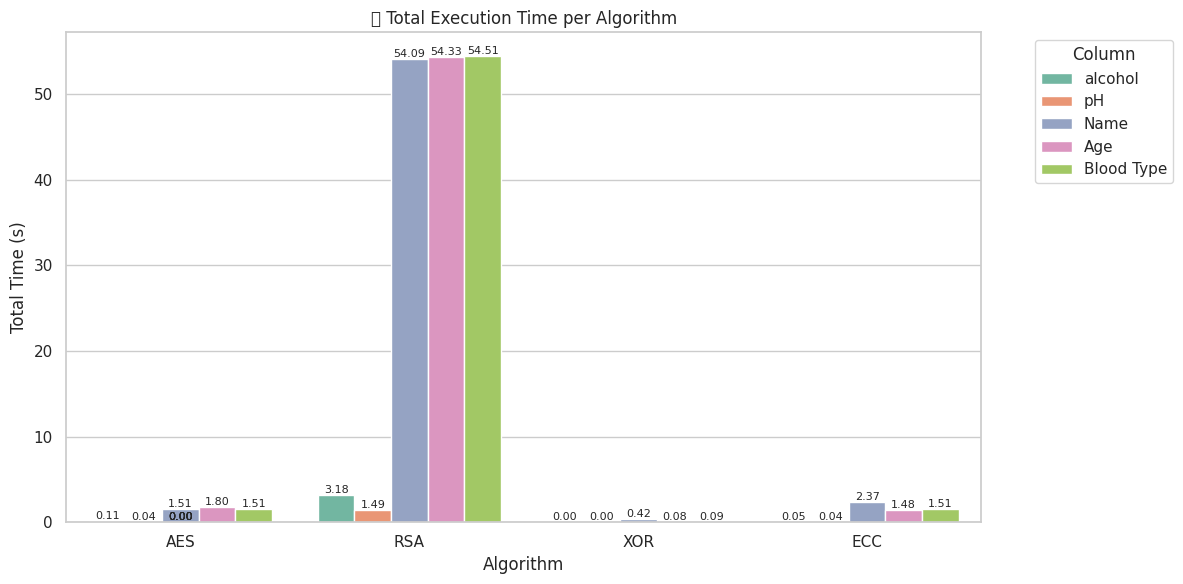

<ipython-input-167-8728d377644b>:18: UserWarning: Glyph 128272 (\N{CLOSED LOCK WITH KEY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128272 (\N{CLOSED LOCK WITH KEY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


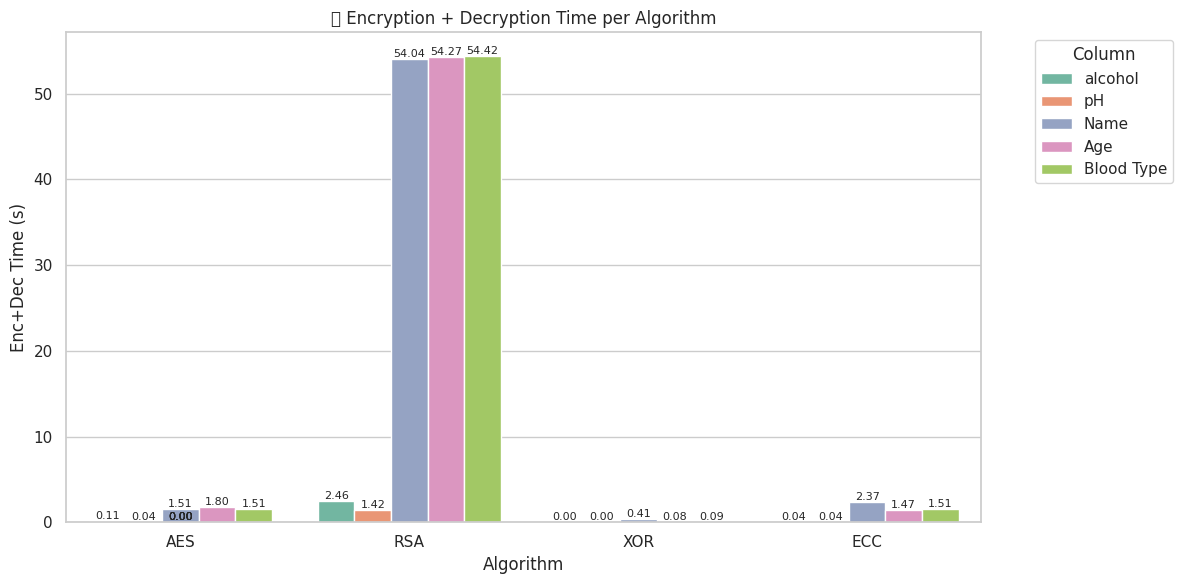

<ipython-input-167-8728d377644b>:18: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


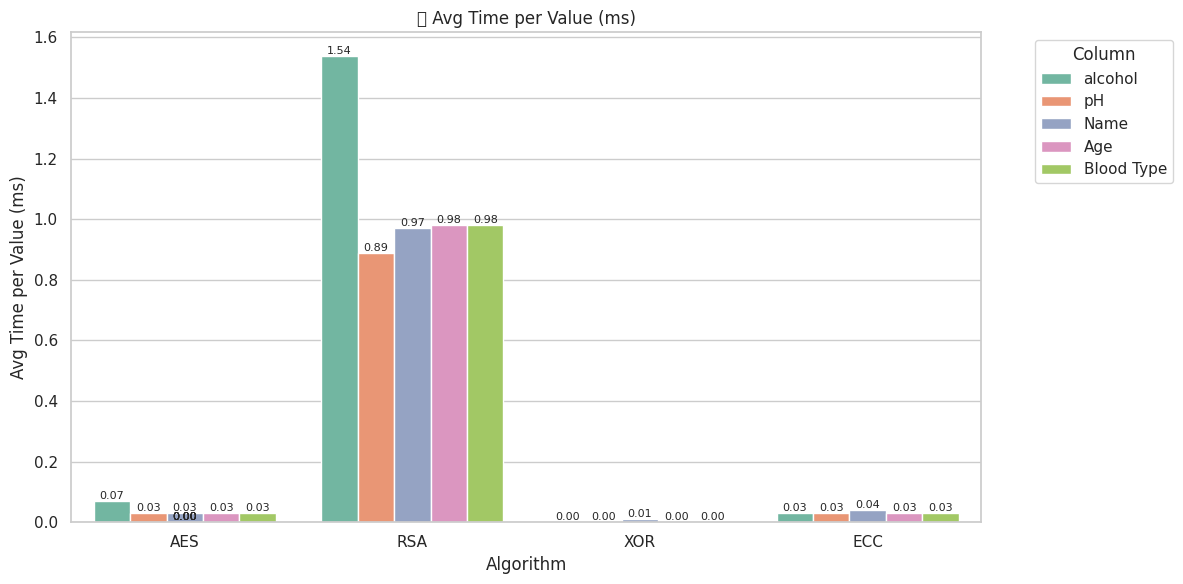

<ipython-input-167-8728d377644b>:18: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


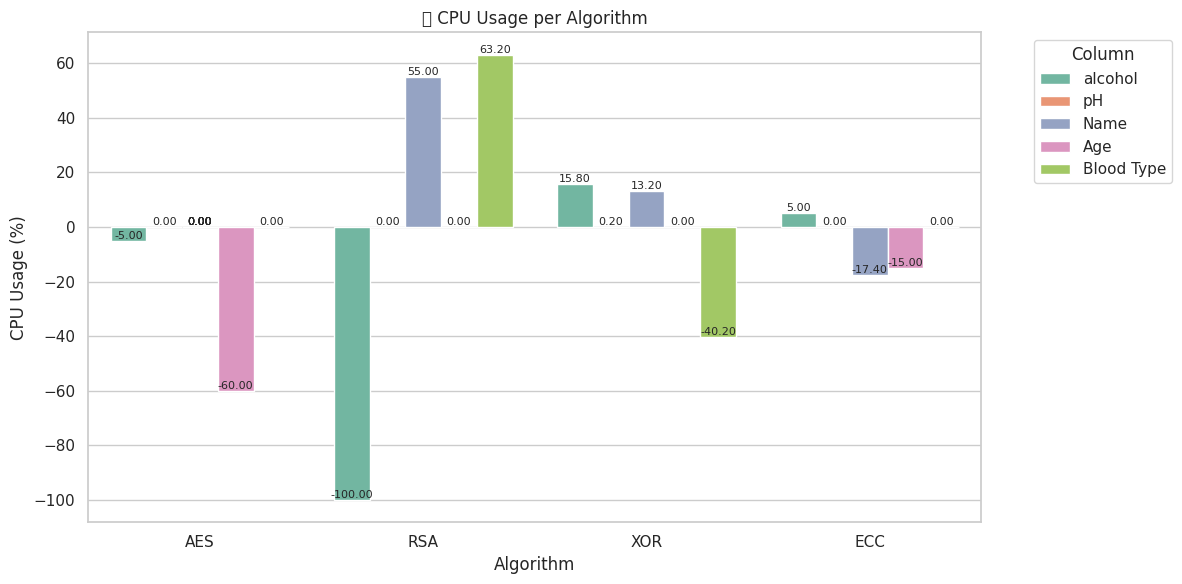

<ipython-input-167-8728d377644b>:18: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


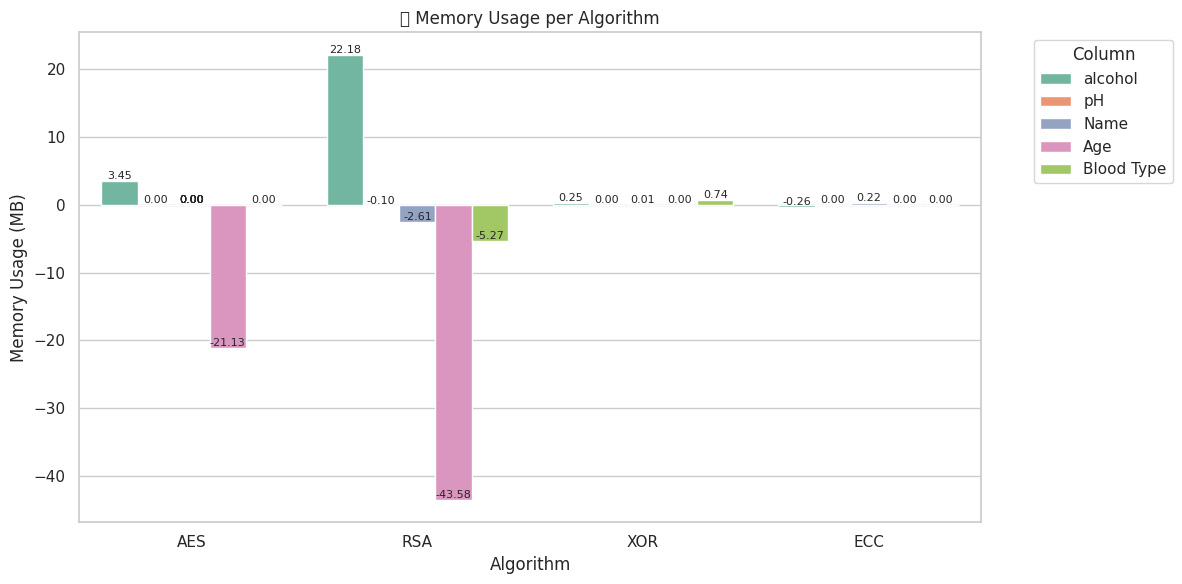

In [168]:
# Generate comparison plots
plot_comparison("Total Time (s)", "🔁 Total Execution Time per Algorithm")
plot_comparison("Enc+Dec Time (s)", "🔐 Encryption + Decryption Time per Algorithm")
plot_comparison("Avg Time per Value (ms)", "⏱️ Avg Time per Value (ms)")
plot_comparison("CPU Usage (%)", "🧠 CPU Usage per Algorithm")
plot_comparison("Memory Usage (MB)", "📊 Memory Usage per Algorithm")

In [169]:
# Function to determine the best algorithm for a given dataset
def best_algorithm_for_dataset(df, dataset_name):
    # Filter the dataset by dataset name (Wine or Health)
    dataset_results = df[df['Dataset'] == dataset_name]

    # Find the algorithm with the minimum total time (for performance comparison)
    best_algorithm = dataset_results.loc[dataset_results['Total Time (s)'].idxmin()]

    print(f"🏆 Best Algorithm for {dataset_name} Dataset:")
    print(f"Algorithm: {best_algorithm['Algorithm']}")
    print(f"Total Time (s): {best_algorithm['Total Time (s)']}")
    print(f"Avg Time per Value (ms): {best_algorithm['Avg Time per Value (ms)']}")
    print(f"CPU Usage (%): {best_algorithm['CPU Usage (%)']}")
    print(f"Memory Usage (MB): {best_algorithm['Memory Usage (MB)']}")
    print("\n")


In [170]:
# Analyze results for both Wine and Health datasets
best_algorithm_for_dataset(benchmark_df, "Wine")
best_algorithm_for_dataset(benchmark_df, "Health")

🏆 Best Algorithm for Wine Dataset:
Algorithm: XOR
Total Time (s): 0.003
Avg Time per Value (ms): 0.0
CPU Usage (%): 15.8
Memory Usage (MB): 0.25


🏆 Best Algorithm for Health Dataset:
Algorithm: XOR
Total Time (s): 0.0831
Avg Time per Value (ms): 0.0
CPU Usage (%): 0.0
Memory Usage (MB): 0.0


